### Number of Clusters

분할 알고리즘은 비중첩 군집의 구성을 발견한다. 여기서 연구자는 정확한 군집 수를 제공해야 한다. 실무적으로 연구자는 군집 수가 얼마인지 미리 알 수 없다. **elbow method**은 설명되는 분산의 한계 비율이 미리 정의한 임계값을 초과하지 않을 때 군집을 더 이상 추가하지 않는 인기 있는 기법이다. 이 맥락에서 설명되는 분산의 비율(percentage of variance explained) 혹은 분산 대비 그룹 간 분산의 비율(일종의 F 테스트)로 정의된다. 이 접근법의 한 가지 결함은 임계값이 종종 임의로 설정된다는 것이다(Goutte et al. 1999).

4.4절에서 셔플된 블록 대각 상관 행렬(block-diagonal correlation)로부터 군집 수를 복구하는 한 가지 알고리즘을 소개한다. 로페즈 데 프라도와 루이스(2018)는 이 알고리즘을 $\text{ONC}$로 표기한다. 이유는 이 알고리즘은 최적 군집수(optimal number of clusters)를 찾기 때문이다. $\text{ONC}$는 실루엣 방법(silhouette method)을 적용하는 더 커다란 클래스의 알고리즘에 속한다(Rousseeuw 1987). 여기서는 상관계수 행렬 내에 군집 수를 발견하는 데 전형적으로 초점을 맞추지만 이 알고리즘은 어떠한 일반적인 관측 행렬에도 적용될 수 있다.



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from FinancialMachineLearning.data_loader.tickers import WikipediaStockListing
from curl_cffi import requests

tickers = WikipediaStockListing()
sp100_tickers = tickers.sp100()['Symbol'].tolist()

session = requests.Session(
    impersonate = 'chrome'
)

data = yf.download(
    sp100_tickers,
    start = '2020-01-01',
    progress = False,
    auto_adjust = True,
    interval = '1d',
    session = session
)['Close'].resample('W-FRI').last()

ret = data.pct_change().iloc[1:]

#### 1. Observations Matrix

만약 문제가 상관계수 행렬과 관련되지 않거나 또는 이미 관측 행렬을 보유하고 있다면 이 절을 생략해도 좋다. 아니면 상관계수 행렬 $\rho$에 의해 특정지워지는 다변수 정규 분포를 따르는 $N$개의 변수를 갖고 있다고 가정하자. 여기서 $\rho_{i,j}$는 변수 $i$와 $j$ 간의 상관계수다. 만약 강한 공통 원소가 존재하면 2장에서 설명한 주응 제거 방법을 적용함으로써 이를 제거하는 것을 권장한다. 왜냐하면 모든 변수에 의해 공유하는 요인 노출을 부분적으로 공유하는 노출의 존재를 감출 수 있기 때문이다.

상관관계 군집화의 목적을 위해서 적어도 다음 3개의 접근법을 따른다.

1. 거리 행렬을 $d_{i,j} = \sqrt{\frac{1}{2}\left(1-\rho_{i,j}\right)}$또는 유사한 변환으로 직접 정의함으로써 $X$ 행렬을 유회할 수 있다(3장 참고).
2. 상관관계 행렬을 $X$로 사용한다.
3. $X$ 행렬을 $X_{i,j} = \sqrt{\frac{1}{2}\left(1-\rho_{i,j}\right)}$ 또는 유사한 변환(거리 접근법의 거리)으로 도출한다.

대안 2와 3의 이점은 두 변수 간의 거리는 단 하나가 아닌 다음 상관관계 추정치의 함수가 될 것이다. 이는 군집화를 더 견고하게 하고, 덜 민감하게 만든다. 대안 3의 이점은 $\rho_{i,j} = 0.9$에서 $\rho_{i,j} = 1.0$으로의 변화가 $\rho_{i,j} = 0.1$에서 $\rho_{i,j} = 0.2$로의 변화보다 더 크다는 것을 인정하는 것이다.

이번 절에서는 3 접근법을 따르며, 관측 행렬을 $X_{i,j} = \sqrt{\frac{1}{2}\left(1-\rho_{i,j}\right)}$로 정의한다.

상관관계 행렬의 군집화는 특성이 관측과 일치한다는 점에서 특별하다. 관측 그 자체가 특성(따라서 $X$의 대칭성)이 관측들을 그룹화하고자 한다. 행렬 $X$는 거리 행렬같아 보이지만, 그렇지 않다. 그러나 여전히 거리가 평가될 수 있는 관측 행렬이다.

$\text{PCA}$를 통해 대형 행렬 $X$를 차원 축소하는 것은 일반적으로 좋은 관행이다. 아이디어는 $X$를 더 저차원 공간에서의 표준화된 직교 투영으로 대체하는 것이다. 여기서 차원수는 $\lambda^+$를 초과하는 $X$의 상관관계 행렬 고유값 수에 의해 주어진다(Chapter 2 참고). 결과물은 크기 $N \times F$의 관측 행렬 $\tilde{X}$로 높은 신호대 잡음 비율을 가진다.

In [2]:
from FinancialMachineLearning.metrics.distance import DistanceDataFrame

distance = DistanceDataFrame(ret)
corr_based_dist = distance.corr_based_distance()

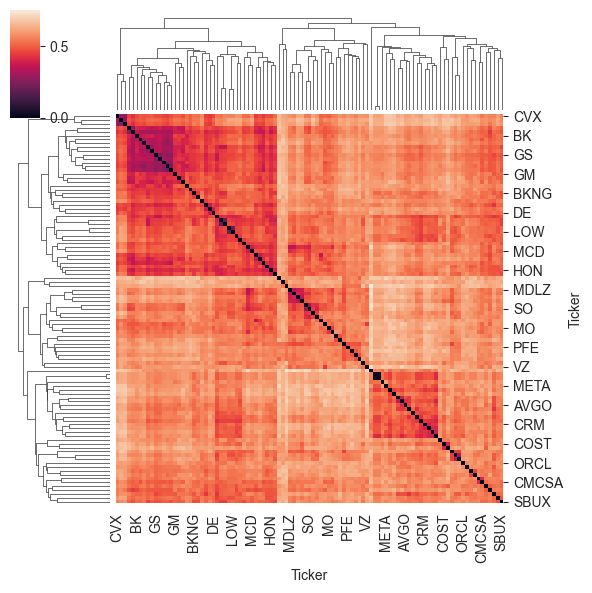

In [3]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.clustermap(corr_based_dist, figsize = (6, 6))

#### 2. Base Clustering

이번 단계에서 척도 공간에서의 관측을 표현하는 행렬을 갖고 있다고 가정한다. 이 행렬은 1절에서 기술된 바와 같은 방식 또는 다른 방법을 적용해 계산됐다고 가정한다. 예를 들어, 이 행렬은 Chapter 3에서 설명한 랜덤 변수 간의 정보 변환을 기반으로 할 수 있다. 다음 기본 군집화 알고리즘을 논의하자. 한 가지 가능성은 관측 행렬에 대해 K-means 알고리즘을 사용하는 것이다. K-means가 단순하고 많은 경우 유효한 반면, 2개의 눈에 띄는 제약을 가진다. 첫째, 알고리즘은 사용자 설정의 군집 수 $K$ 를 요구하는데 이것이 선험적으로 반드시 최적인지는 보장할 수 없다. 둘째, 초기화가 랜덤이어서 알고리즘의 결과가 유사하게 랜덤일 수 있다.

이러한 두 우려를 해결하고자 K-means 알고리즘을 수정해야 한다. 첫째 수정은 ‘최적 $K$’를 발견할 수 있도록 목적 함수를 도입하는 것이다. 이를 위해 Rousseeuw(1987)에 의해 도입된 실루엣 점수를 취한다. 주어진 원소 $i$와 주어진 군집화에 대해 실루엣 지수 $S_i$는 다음과 같이 정의되는 것을 상기하자.

$$S_i = \frac{b_i - a_i}{\max\{a_i, b_i\}}; \qquad i = 1, \dots, N$$

여기서 $a_i$는 동일한 군집 내의 $i$와 다른 모든 원소와의 평균 거리이고, $b_i$는 $i$와 $i$가 그 구성원이 아닌 최근접 군집 내의 모든 원소와의 평균 거리다. 실질로 이는 군집 내 거리와 군집 간 거리를 비교하는 척도다. 값 $S_i=1$은 원소 $i$가 잘 군집화됐다는 의미이며, $S_i = -1$은 $i$가 잘 군집화되지 못했다는 것을 의미한다. 주어진 분할에 대해 군집화 품질의 척도 $q$는 다음과 같이 정의된다.

$$q = \frac{E\left[\left\{S_i\right\}\right]}{\sqrt{V[\{S_i\}]}}$$

여기서 $E[\{S_i\}]$는 실루엣 지수의 평균이고, $V[\{S_i\}]$는 실루엣 지수의 분산이다. 두 번째 수정은 k-평균의 초기화 문제를 다룬다. 기본 수준에서 군집화 알고리즘은 다음 연산을 수행한다.

- 첫째, 관측 행렬을 평가한다.
- 둘째, 이를 for loop로 수행한다. 첫 번째 루프에서 하나의 주어진 초기화에 대해 k-means를 통해 군집화한 상이한 $k=2,\dots,N$을 시도하고, 각 군집화에 대해 품질 $q$를 평가한다. 두 번째 루프는 첫 번째 루프를 여러 번 반복하고, 그에 따라 상이한 초기화를 시도한다.
- 셋째, 이들 두 루프에 대해 가장 높은 $q$를 가진 군집화를 선택한다.

아래 코드는 이 절차를 구현하고, 그림은 작업 흐름을 요약한다.

In [6]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase

corr1, clus_kmeans, silh_coefficient_optimal = clusterKMeansBase(
    corr0 = ret.corr(),
    maxNumClusters = 10,
    n_init = 10,
    verbose = True
)

KMeans(n_clusters=2, n_init=10)
(np.float64(1.74757189322362), nan)
For n_clusters =2The average silhouette_score is :0.2075177966958381
********
KMeans(n_clusters=3, n_init=10)
(np.float64(1.8235585066321602), np.float64(1.74757189322362))
For n_clusters =3The average silhouette_score is :0.22200675591057217
********
KMeans(n_clusters=3, n_init=10)
(np.float64(1.826883348743469), np.float64(1.8235585066321602))
For n_clusters =3The average silhouette_score is :0.2220500948111208
********


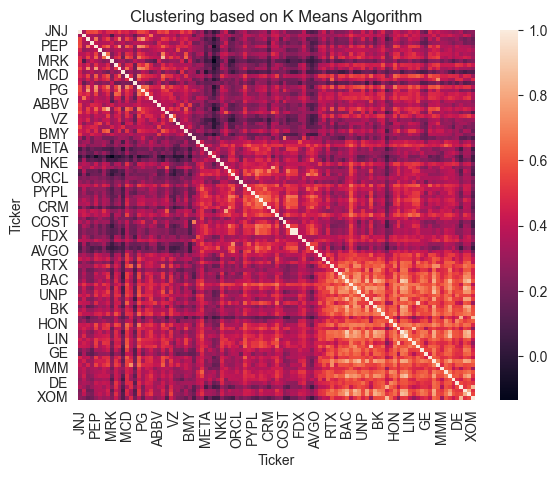

In [11]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.heatmap(corr1)
plt.title('Clustering based on K Means Algorithm')
plt.show()

#### 3. Higher Level Clustering

k-평균에 대한 세 번째 수정은 품질의 일관성이 없는 군집을 다룬다. 기본 군집화는 거리가 더 먼 군집들을 포착하지만, 덜 뚜렷한 것들을 놓친다. 이 문제를 다루고자 기본 군집화 알고리즘으로부터 군집화 품질 점수가 주어졌을 때 각 군집 $k=1,\dots,K$의 품질 $q_k$를 평가한다. 그다음 평균 품질 $q$를 취해 평균보다 낮은 품질의 군집 집합 $\{q_k|q_k < \bar{q}, k=1,\dots,K\}$를 발견한다. $K_1, K_1 < K$를 그 집합의 군집 수라고 표기하자. 만약 반환할 군집 수가 $K_1 \leq 1$이라면 기본 알고리즘에 의해 주어진 알고리즘을 반환한다. 그러나 만약 $K_1 \geq 2$라면 $K_1$개의 군집 내의 원소들에 대해 군집화를 다시 실행한다. 반면 나머지 원소들은 수용될 수 있도록 군집화가 된 것으로 간주한다.

 군집 $K_1$를 구성하는 원소들로부터 (축소된) 새로운 관측 행렬을 형성하고, 이 축소된 상관관계 행렬에 대한 기본 군집화 알고리즘을 다시 실행한다. 이렇게 하면 이들 $K_1$ 군집의 원소들에 대해 (아마도) 새로운 군집화를 반환할 것이다. 그 효율성을 검증하고자 $K_1$의 원소들을 재군집화하기 전과 후의 평균 군집 품질을 비교한다. 만약 평균 군집 품질이 개선되면 새로 실행한 노드에 대한 새로운 군집화와 기본 군집화로부터 수용된 군집화를 병합해 돌려준다.

아래의 코드는 파이썬으로 이 연산을 구현하고, 그림은 작업 흐름을 요약한다.

In [15]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansTop

corr2, clus_kmeans_top, silh_coefficient_optimal_top = clusterKMeansTop(
    corr0 = ret.corr(),
    maxNumClusters = None,
    n_init = 10,
)

clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[np.int32(1), np.int32(2)] clstrs len:3


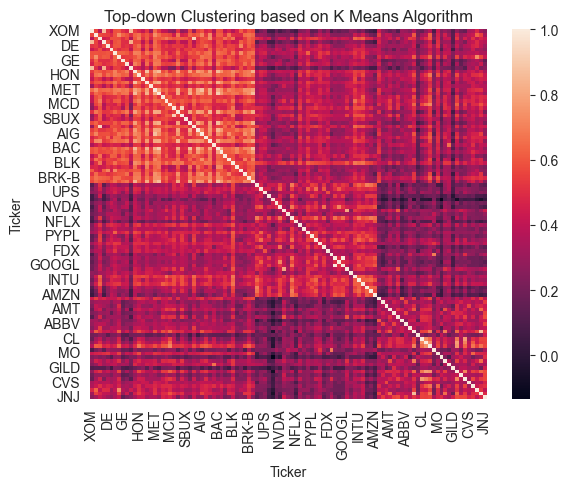

In [16]:
sns.heatmap(corr2)
plt.title('Top-down Clustering based on K Means Algorithm')
plt.show()